# Research Notebook #3
## Belen Llaguno
## Date: February 18 - March 3

# 1: Experience
## Describe at least one research activity you worked on this week.
- Read the paper "Splashback in accreting dark matter halos" (Adhikari et al. 2014) [2]
-  Attempted to recreate the splashback.py function to generalize the Adhikari model.


## Motivation:

The splashback radius is crucial in the study of dark matter halos. Accurately modelling this radius provides essential insights into the structure and evolution of halos. The semi-analytical model of Adhikari et al. (2014) describes the splashback radius for cold dark matter (CDM). However, alternative dark matter models, such as fuzzy dark matter (FDM) and self-interacting dark matter (SIDM), introduce additional physical effects that could alter halo dynamics. Generalizing the Adhikari code to different dark matter models allows us to explore how their fundamental properties influence the splashback radius. Implementing these extensions into the COLOSSUS code allows for systematic comparisons between different models, helping to refine our theoretical understanding of dark matter and its role in cosmic structure formation.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

I read the Adhikari et. al 2014 paper [2] to understand the equations and how they're applied into the model. Then I wrote code that would allow me to recreate the splashback radius plot, how much it differs from the model used in the paper, and the enclosed overdensity profile.It took me multiple attempts as I kept running into errors and struggled with the logic of the code. I arrived to a plot that was close but not exactly as the one used in the paper. However, I do not know how to implement it into COLOSSUS, that step is beyond my knowledge and understanding of Python programming. I could not figure out how to include the different mass profiles, uniformly distributed when the radius is smaller than half the turn around radius, and the NFW distribution when the radius is larger than half the turnaround radius.

####Code (won't run unless the first two cells are excecuted):

In [2]:
pip install colossus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 3.4 MB/s eta 0:00:00


In [3]:
from colossus.cosmology import cosmology
cosmology.setCosmology('bolshoi');

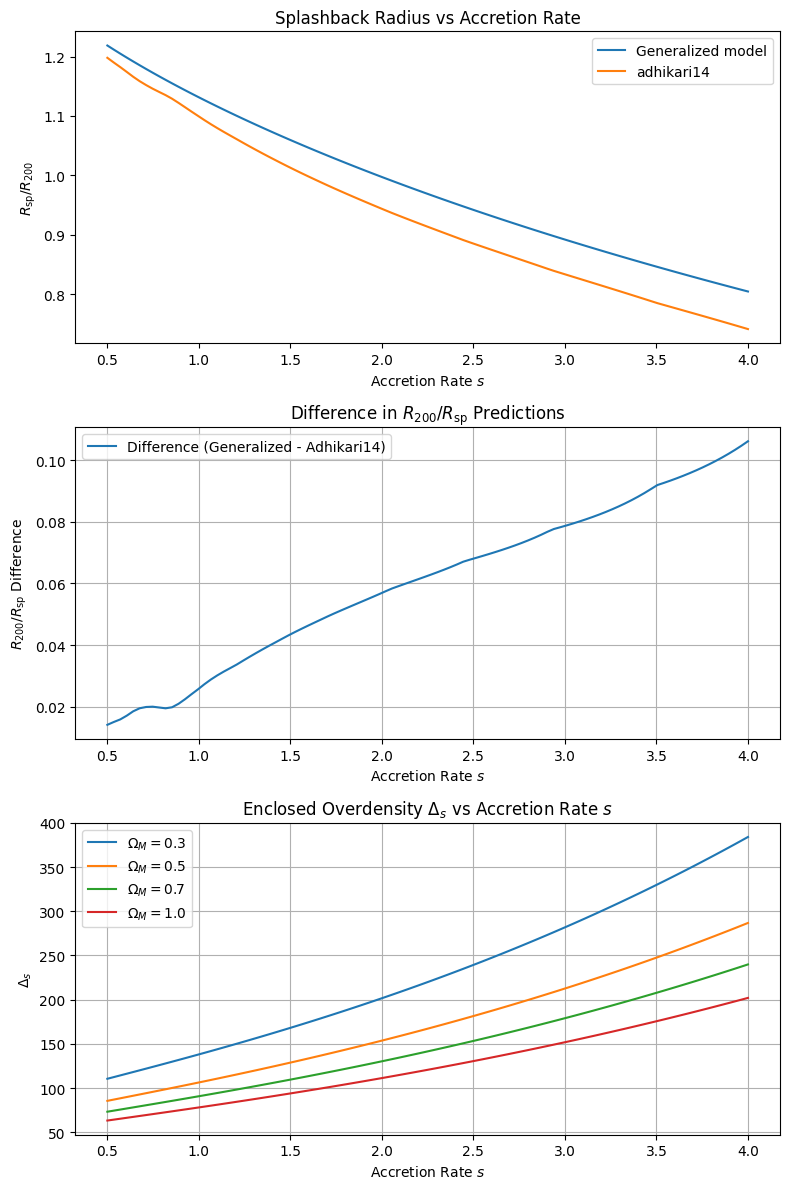

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from colossus.lss import peaks
from colossus.halo import splashback

# Constants
G = 4.302e-9  # Gravitational constant in Mpc/Msun (km/s)^2
H0 = 70.0  # Hubble constant in km/s/Mpc
Omega_M = 0.3  # Matter density parameter
Omega_Lambda = 0.7  # Dark energy density parameter
rho_crit = 3 * H0**2 / (8 * np.pi * G)  # Critical density

# Fitting parameters for Delta_s
A = 38
b = 0.57
c = 0.02
d = 0.2
e = 0.52

# NFW profile function
def f_NFW(x):
    return np.log(1 + x) - x / (1 + x)

# Mass profile for r > r_ta / 2
def mass_profile(r, M_tot, r_s, R):
    return M_tot * f_NFW(r / r_s) / f_NFW(R / r_s)

# Equation of motion for spherical collapse
def equation_of_motion(y, t, M, Lambda):
    r, v = y
    drdt = v
    dvdt = -G * M / r**2 + (Lambda * (3e5)**2 / 3) * r  # Lambda in (km/s)^2/Mpc^2
    return [drdt, dvdt]

# Compute Delta_s from accretion rate s
def delta_s(s, Omega_M):
    return A * Omega_M**(-b - c * s) * np.exp(d * Omega_M + e * s**(3/4))

# Main function to compute Delta_s for a range of s values
def compute_delta_s(s_values, Omega_M):
    Delta_s_values = []
    for s in s_values:
        Delta_s_values.append(delta_s(s, Omega_M))
    return Delta_s_values

# Compute R200 (radius where density is 200 times critical density)
def R200(M200):
    return (3 * M200 / (800 * np.pi * rho_crit))**(1/3)

# Main function to compute splashback radius
def compute_splashback(s, M200, r_s, Omega_M):
    # Compute R200
    R200_val = R200(M200)

    # Compute Delta_s
    Delta_s_val = delta_s(s, Omega_M)

    # Compute Rsp / R200
    Rsp_over_R200 = (Delta_s_val / 200)**(-1/3)

    return Rsp_over_R200, Delta_s_val

# Plotting functions
def plot_results(s_values, Rsp_over_R200_values, Delta_s_values, Omega_M_values):
    plt.figure(figsize=(8, 12))
    R200_val = R200(M200)

    # Plot Rsp / R200 vs s
    plt.subplot(3, 1, 1)
    plt.plot(s_values, Rsp_over_R200_values, '-', label='Generalized model')
    plt.xlabel('Accretion Rate $s$')
    plt.ylabel('$R_{\\mathrm{sp}} / R_{200}$')
    plt.title('Splashback Radius vs Accretion Rate')

    # Calculate and plot Rsp / R200 for the 'adhikari14' model
    model_name = 'adhikari14'
    nu200m = peaks.peakHeight(M200, z=0.0)  # Redshift z = 0.0
    RspR200m, mask = splashback.splashbackModel('RspR200m', Gamma=s_values, nu200m=nu200m, z=0.0,
                                               model=model_name, rspdef='sp-apr-p75', statistic='median')
    plt.plot(s_values[mask], RspR200m, label=model_name.replace('_', '\\_'))

    plt.legend()

    # Compute the difference in R200/Rsp between the two models
    R200_over_Rsp_generalized = 1 / np.array(Rsp_over_R200_values)
    R200_over_Rsp_adhikari = 1 / RspR200m

    difference = np.abs(R200_over_Rsp_generalized[mask] - R200_over_Rsp_adhikari)

    # Plot the difference
    plt.subplot(3, 1, 2)
    plt.plot(s_values[mask], difference, '-', label='Difference (Generalized - Adhikari14)')
    plt.xlabel('Accretion Rate $s$')
    plt.ylabel('$R_{200} / R_{\\mathrm{sp}}$ Difference')
    plt.title('Difference in $R_{200} / R_{\\mathrm{sp}}$ Predictions')
    plt.legend()
    plt.grid(True)

    # Plot Delta_s vs s for multiple omega_M values
    plt.subplot(3, 1, 3)
    for Omega_M in Omega_M_values:
        Delta_s_values = compute_delta_s(s_values, Omega_M)
        plt.plot(s_values, Delta_s_values, label=f'$\\Omega_M = {Omega_M}$')

    plt.xlabel('Accretion Rate $s$')
    plt.ylabel('$\\Delta_s$')
    plt.title('Enclosed Overdensity $\\Delta_s$ vs Accretion Rate $s$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
s_values = np.linspace(0.5, 4, 100)  # Accretion rate range
M200 = 1e14  # Halo mass in Msun
r_s = 0.1  # NFW scale radius in Mpc

Omega_M_values = [0.3, 0.5, 0.7, 1.0]  # Different Omega_M values

Rsp_over_R200_values = []
Delta_s_values = []

for s in s_values:
    Rsp_over_R200, Delta_s = compute_splashback(s, M200, r_s, Omega_M)
    Rsp_over_R200_values.append(Rsp_over_R200)
    Delta_s_values.append(Delta_s)

plot_results(s_values, Rsp_over_R200_values, Delta_s_values, Omega_M_values)

# 3: So what? (What does it mean?)
## Describe your results

Splashback radius plotted by COLOSSUS Adhikari14 model, generalized model

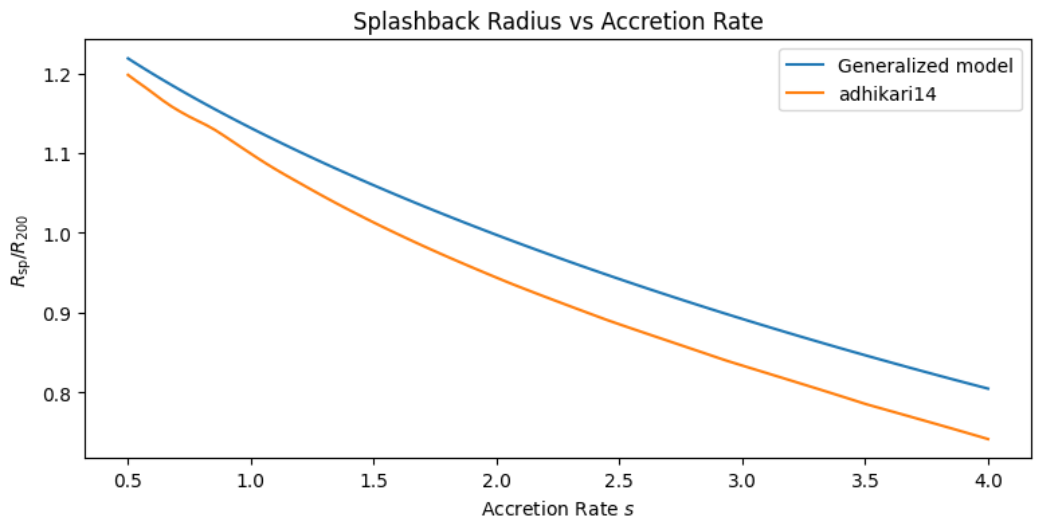




Difference between the two predictions:

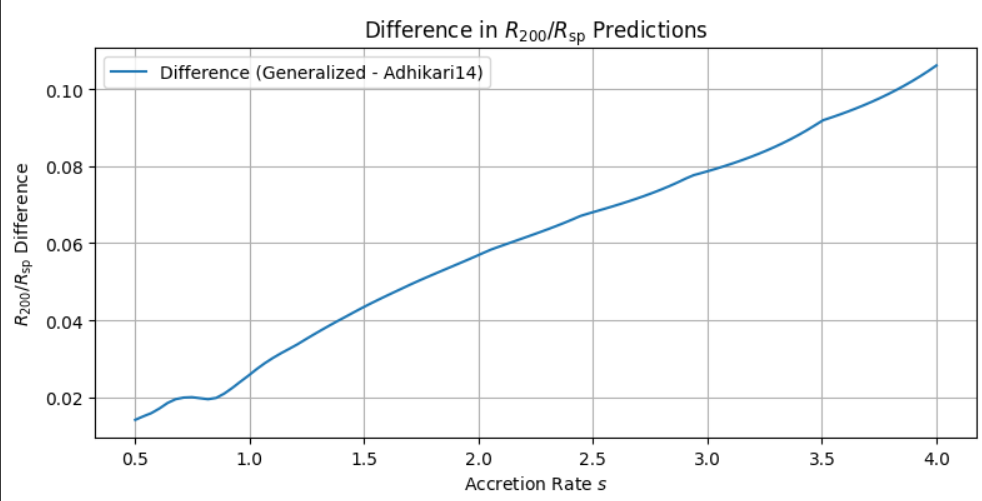






I'm not sure where the difference is coming from, I will look into it over the next few weeks.




Enclosed overdensity plot by generalized model:

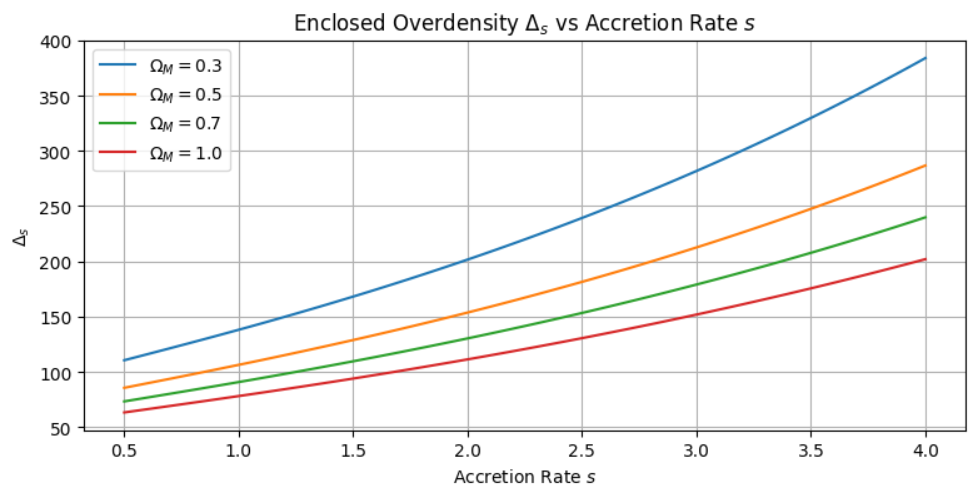



Enclosed overdensity plot in the Adhikari et. al 2014 paper [2]:

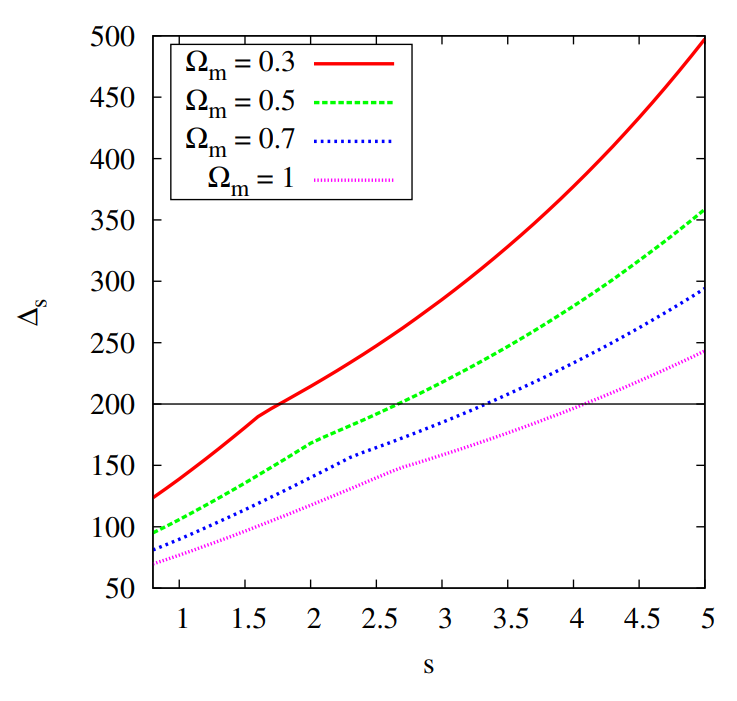


The difference here comes from the mass distibution which I need to fix.

# 4. Now what? (What's next?)
## Plan for the next week

- Figure out how to implement the generalized model into COLOSSUS.
- Try to make a more accurate model that's closser to the one used in Adhikari et. al 2014.
- Figure out how to include the two mass profiles for more accurate plots.

# 5. Bibliography

[1]  B. Diemer, “COLOSSUS: A Python Toolkit for Cosmology, Large-scale Structure, and Dark Matter Halos,” The Astrophysical Journal Supplement Series 239(2), 35 (2018).


[2]  Adhikari S, Dalal N, Chamberlain RT. Splashback in accreting dark matter halos. Journal of Cosmology and Astroparticle Physics. 2014;2014(11):019-019. doi:https://doi.org/10.1088/1475-7516/2014/11/019

